In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

## Getting and converting the data 

In [28]:
doc(untar_data)

In [3]:
path = untar_data(URLs.BIWI_HEAD_POSE, dest="data")

In [40]:
path = "/home/ricky/Desktop/repos/fastai_course"/path

In [43]:
path

PosixPath('/home/ricky/Desktop/repos/fastai_course/data/biwi_head_pose')

In [44]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6); cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

In [45]:
fname = '09/frame_00667_rgb.jpg'

In [46]:
def img2txt_name(f):
    return path/f'{str(f)[:-7]}pose.txt'

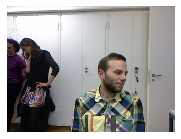

In [47]:
img = open_image(path/fname)
img.show()

In [48]:
img2txt_name(fname)

PosixPath('/home/ricky/Desktop/repos/fastai_course/data/biwi_head_pose/09/frame_00667_pose.txt')

In [49]:
ctr = np.genfromtxt(img2txt_name(fname), skip_header=3); ctr

array([187.332 ,  40.3892, 893.135 ])

In [50]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0]/coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1]/coords[2] + cal[1][2]
    return tensor([c2, c1])

def get_ctr(f):
    ctr = np.genfromtxt(img2txt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img, pts):
    return ImagePoints(FlowField(img.size, pts), scale=True)

In [51]:
get_ctr(fname)

tensor([263.9104, 428.5814])

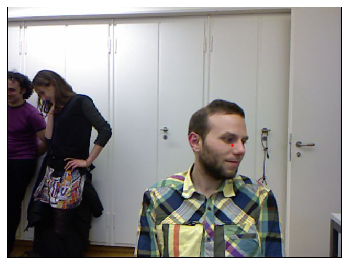

In [52]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6,6))

## Creating a dataset 

In [56]:
data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(get_transforms(), tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

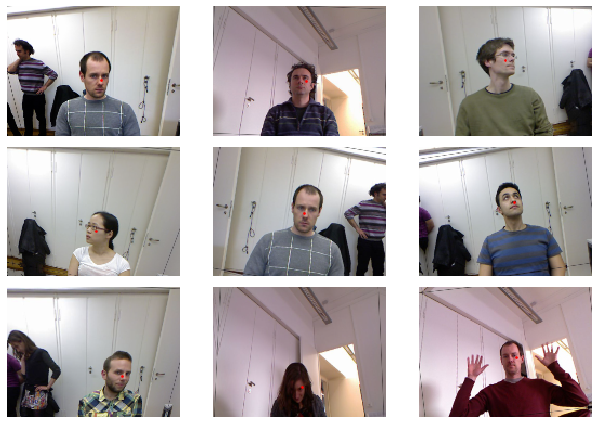

In [57]:
data.show_batch(3, figsize=(9,6))

## Train model 

In [58]:
learn = cnn_learner(data, models.resnet34)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


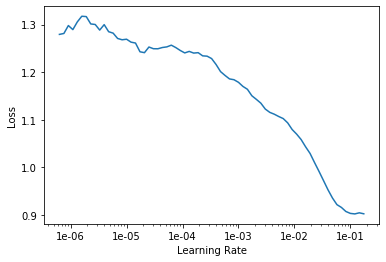

In [59]:
learn.lr_find()
learn.recorder.plot()

In [60]:
lr = 2e-2

In [61]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.043816,0.006420,00:52
1,0.015702,0.005017,00:52
2,0.008084,0.000818,00:53
3,0.004647,0.000516,00:53
4,0.003793,0.001181,00:53


In [62]:
learn.save("stage-1")

In [63]:
learn.load("stage-1");

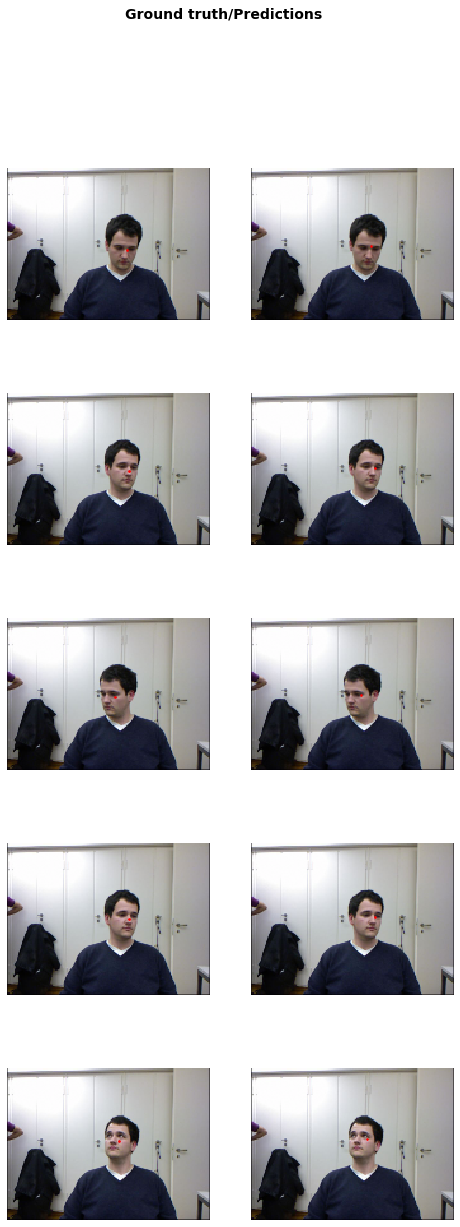

In [64]:
learn.show_results()

## Data augmentation 

In [66]:
tfms = get_transforms(max_rotate=20,
                      max_zoom=1.5,
                      max_lighting=0.5,
                      max_warp=0.4,
                      p_affine=1.,
                      p_lighting=1.)

data = (PointsItemList.from_folder(path)
        .split_by_valid_func(lambda o: o.parent.name=='13')
        .label_from_func(get_ctr)
        .transform(tfms, tfm_y=True, size=(120,160))
        .databunch().normalize(imagenet_stats)
       )

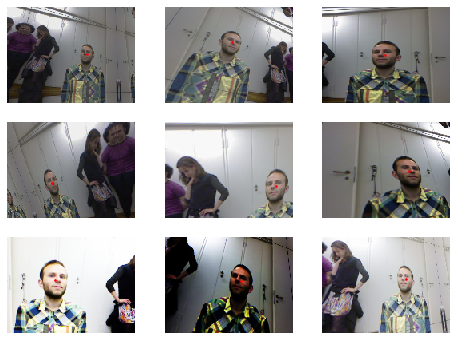

In [69]:
def _plot(i, j, ax):
    x, y = data.train_ds[0]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8,6))